(coalescent_intro)=

# Introduction

The next several chapters discuss methods for simulating the genealogy of a sample.
This branch of population genetics is called coalescent theory and it provides an explicit generative model for data.
Typically, this model is a null model not involving selection, but this assumption can be relaxed to some extent.

These chapters should accompany texts discussing the relevant theory.
Examples appropriate for graduate-level courses are:

* Wakeley's excellent book. {cite}`Wakeley2008-hd`.
* Hudson's seminal 1990 review {cite}`Hudson1990-ff`
* Nordborg's chapter in *Handbook of Statistical Genetics*. {cite}`Nordborg2004-xy`
* Rosenberg and Nordborg's review. {cite}`Rosenberg2002-ac`

## Factors of two

A constant source of confusion to people learning about coalescent models has to do with time scaling.
As discussed in the references above, time is measured in continuous units with respect to the (effective) population size.
Thus, we may say that an event occurred $\tau = \frac{g}{2N_e}$ time units ago, where $g$ is the number of generations.
Here, $\tau$ is a measure of time in units of $2N_e$ generations.

Sadly, factors of two are casually ignored, omitted, or forgotten about entirely when explaining the meaning of analytical expressions or how various software tools work.
To the best of my ability, all time units presented here will be in units of $2N_e$ generations.
This scaling differs from how Hudson's `ms` program ({cite}`Hudson2002-oo`), which itself differs from Kelleher *et al.*'s `msprime` ({cite}`Kelleher2016-cb`).
We will make note of differences in scaling as necessary.

## Representing trees

The tree shown below was generated using [msprime](https://msprime.readthedocs.io) ({cite}`Kelleher2016-cb`,{cite}`Kelleher2020-zf`)
We will discuss this software in later chapters.

This tree is a random sample from the Kingman coalescent.
This tree shows the ancestral history of a present-day sample of $n = 5$ randomly-chosen samples.
Each node on the tree (small black circles) are labelled with `id: (time, parent id)`.
The `id` is an *index* that uniquely identifies each node.

This tree has the following properties:

* Our present-day samples have `id` values from $[0, n)$.
* Teach present-day node has a time of 0.
* Time increases into the past.
* Time is measured in units of $N_e$ generations.
  Note: not $2N_e$!!!
* There are a total of $2n - 1$ nodes.
* The root node has `id` 8.
  The parent `id` of this node has a value of -1, which we interpret as `NULL`.
  This `NULL` indicates that there is no parent, thus indicating that this is a root node.

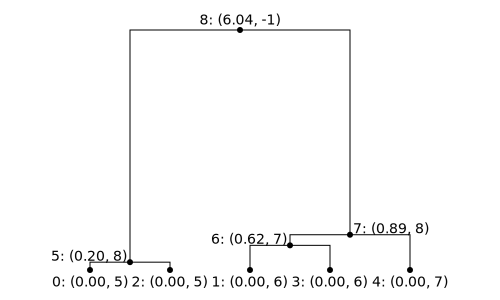

In [1]:
import msprime
import pandas as pd
from IPython.display import SVG

ts = msprime.simulate(5, random_seed=987632)
t = ts.first()
nodes = sorted([i for i in t.nodes()])
df = pd.DataFrame({"parent": [t.parent(i) for i in nodes],
                   "time": [ts.tables.nodes.time[i] for i in nodes]})
df.index.name = "node"
node_labels = {i: f"{i}: ({ts.tables.nodes.time[i]:.2f}, {t.parent(i)})" for i in nodes}
SVG(t.draw(format="svg",height=300, width=500, node_labels=node_labels))

For reasons of computational efficiency, it is convenient to represent these tree structures as a collection of arrays.
These collections describe a tree in a table-like format:

In [2]:
df

,parent,time
node,,
0,5,0.000000
1,6,0.000000
2,5,0.000000
3,6,0.000000
4,7,0.000000
5,8,0.197092
6,7,0.620690
7,8,0.887622
8,-1,6.041521


For a given sample size, we need arrays of length $2n - 1$.
We use the `id` of a node to index these arrays, allowing efficient lookup of a node's `parent` or `time`.

These indexed tables are the basis for efficient algorithms on the trees.
The table shown above allows convenient traversal from any node back to the root.
For example, consider the node with `id` 1.
From the above table, that node's `parent` is 6.
The `parent` of 6 is 7.
The `parent` of 7 is 8, which is the root.

We can write this algorithm as follows:

In [3]:
import typing

def path_to_root(node: int, tree: typing.List[int]) -> typing.List[int]:
    u = tree[node];
    path = []
    while u != -1:
        path.append(u)
        u = tree[u]
    return path

Applying it to node 1 gives:

In [4]:
path_from_1 = path_to_root(1, df.parent.tolist())
path_from_1

[6, 7, 8]